In [1]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt
from chronos import Chronos2Pipeline

c:\capstone_project_unfc\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. SETTINGS ---
SYMBOL = "TSLA"
INTERVAL = "1wk"
PERIOD = "5y"
MODEL_ID = "amazon/chronos-2"
TEST_SIZE = 30
MIN_CONTEXT = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# --- 2. DATA LOADING ---
print(f"Fetching {SYMBOL} data...")
df = yf.download(SYMBOL, period=PERIOD, interval=INTERVAL, auto_adjust=False, progress=False)
df = df.reset_index().rename(columns={"Date":"timestamp", "Close":"close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")
prices = df.set_index("timestamp")["close"].astype(float).dropna()

prices.head(), len(prices)

Fetching TSLA data...


In [4]:
# --- 3. MODEL INITIALIZATION (Cached) ---
print(f"Loading {MODEL_ID} on {DEVICE}...")
pipeline = Chronos2Pipeline.from_pretrained(
    MODEL_ID,
    device_map=DEVICE,
    torch_dtype=torch.float32,
)

Loading amazon/chronos-2 on cpu...


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


In [5]:
def chronos_predict_1step(train_series: pd.Series) -> float:
    """
    Chronos-2: Returns median forecast. 
    Uses .flatten() to ensure Pandas doesn't see extra dimensions.
    """
    # Force the data to be 1D to avoid "Per-column arrays must be 1-dimensional"
    target_values = train_series.values.flatten()
    timestamps = train_series.index

    input_df = pd.DataFrame({
        "item_id": ["BTC"] * len(target_values), # Match length of data
        "timestamp": timestamps,
        "target": target_values
    })

    forecast_df = pipeline.predict_df(
        input_df,
        prediction_length=1,
        quantile_levels=[0.5],
        id_column="item_id",
        timestamp_column="timestamp",
        target="target"
    )
    
    # Ensure we return a single float, not a series or array
    return float(forecast_df["0.5"].iloc[0])

In [6]:
def backtest_one_step_chronos(prices_full: pd.Series, test_size: int):
    preds = []
    split_idx = len(prices_full) - test_size

    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        if len(train) < MIN_CONTEXT:
            continue

        ts = prices_full.index[i]
        # Use .item() to ensure y_true is a scalar number
        val = prices_full.iloc[i]
        y_true = float(val.item() if hasattr(val, 'item') else val)
        
        try:
            y_pred = chronos_predict_1step(train)
            preds.append({"timestamp": ts, "y_true": y_true, "y_pred": y_pred})
        except Exception as e:
            print(f"Skipping {ts} due to error: {e}")
            continue

    return pd.DataFrame(preds)

# Run the backtest
pred_chronos = backtest_one_step_chronos(prices, TEST_SIZE)

c:\capstone_project_unfc\env\Lib\site-packages\chronos\chronos2\dataset.py:89: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  task_target = torch.from_numpy(task_target)



--- Metrics ---
MAE:  $18.83
RMSE: $22.26
MAPE: 4.52%


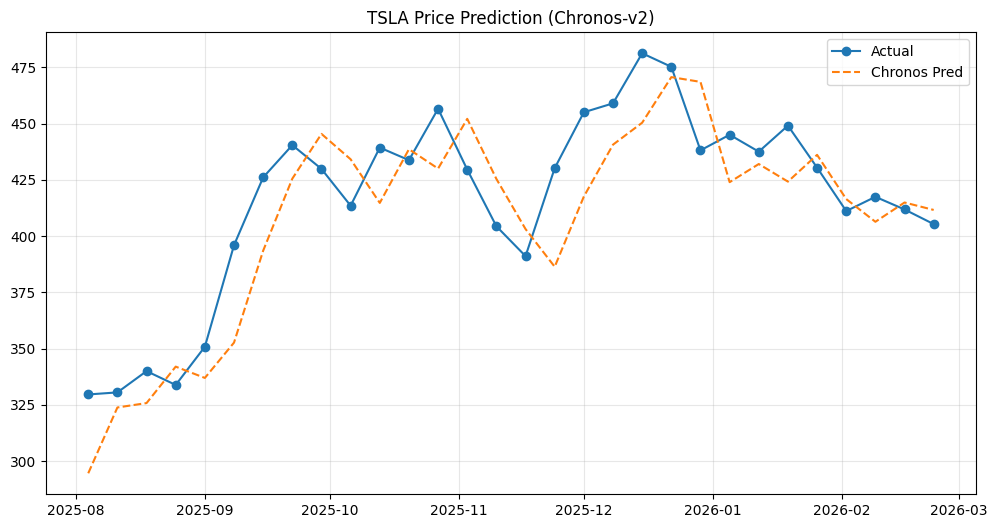

In [10]:
# --- 6. EVALUATION & PLOT ---
def print_metrics(df_p):
    y, yh = df_p["y_true"], df_p["y_pred"]
    mae = np.mean(np.abs(y - yh))
    mape = np.mean(np.abs((y - yh) / y)) * 100
    print(f"\n--- Metrics ---")
    print(f"MAE:  ${mae:,.2f}")
    rmse = sqrt(np.mean((y - yh) ** 2))
    print(f"RMSE: ${rmse:,.2f}")
    print(f"MAPE: {mape:.2f}%")

if not pred_chronos.empty:
    print_metrics(pred_chronos)
    
    plt.figure(figsize=(12, 6))
    plt.plot(pred_chronos["timestamp"], pred_chronos["y_true"], label="Actual", marker='o')
    plt.plot(pred_chronos["timestamp"], pred_chronos["y_pred"], label="Chronos Pred", linestyle='--')
    plt.title(f"{SYMBOL} Price Prediction (Chronos-v2)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No predictions were generated. Check your data and MIN_CONTEXT.")

In [8]:
pred_chronos["timestamp"] = pd.to_datetime(pred_chronos["timestamp"], utc=True)

In [9]:
REPO_ROOT = Path.cwd().parent.parent

OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

path = OUTDIR / "pred_chronos_weekly_price.parquet"

# Save the results
pred_chronos.to_parquet(path, index=False)
print("Saved successfully to:", path)

Saved successfully to: c:\capstone_project_unfc\model\notebooks\artifacts\pred_chronos_weekly_price.parquet
